In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os
import json
import sys
import numpy as np
sys.path.append("..")
import copy
from tqdm.auto import tqdm

In [3]:
from src import models, data, operators, utils, functional, metrics, lens
from src.utils import logging_utils, experiment_utils
import logging
import torch
import baukit

experiment_utils.set_seed(123456)

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format = logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout
)

In [4]:
#################################################
h_layer = 7
beta = 0.4
n_training = 10
#################################################

In [5]:
mt = models.load_model(name = "gptj", fp16 = True, device = "cuda")

2023-06-23 12:57:53 src.models INFO     loading EleutherAI/gpt-j-6B (device=cuda, fp16=True)


In [6]:
relation = data.load_dataset().filter(relation_names=["country capital city"])[0].set(prompt_templates=[" {}:"])
train, test = relation.split(n_training)

In [7]:
icl_prompt = functional.make_prompt(
    prompt_template = train.prompt_templates[0],
    subject = "{}",
    examples = train.samples,
    mt = mt
)
print(icl_prompt)

<|endoftext|> Pakistan: Islamabad
 Argentina: Buenos Aires
 Peru: Lima
 Australia: Canberra
 Germany: Berlin
 Saudi Arabia: Riyadh
 Russia: Moscow
 Italy: Rome
 India: New Delhi
 South Korea: Seoul
 {}:


In [8]:
test = functional.filter_relation_samples_based_on_provided_fewshots(
    mt = mt, 
    test_relation=test,
    prompt_template = icl_prompt,
    batch_size=4
)
len(test.samples)

14

In [9]:
estimator = operators.JacobianIclMeanEstimator(
    mt = mt, h_layer=h_layer, beta=beta
)
operator = estimator(train)

In [10]:
for sample in test.samples:
    pred = operator(sample.subject).predictions[:3]
    print(f"{sample} | pred: {[f'{p.token} ({p.prob:.2f})' for p in pred]}")

Brazil -> Bras\u00edlia | pred: [' Bras (0.74)', ' Rio (0.11)', ' Sao (0.04)']
Canada -> Ottawa | pred: [' Toronto (0.28)', ' Ottawa (0.23)', ' Vancouver (0.10)']
Chile -> Santiago | pred: [' Santiago (0.98)', '  (0.01)', ' Chile (0.01)']
China -> Beijing | pred: [' Beijing (0.96)', ' Shanghai (0.03)', ' China (0.00)']
Colombia -> Bogot\u00e1 | pred: [' Bog (0.76)', '  (0.12)', '\n (0.02)']
Egypt -> Cairo | pred: [' Cairo (0.98)', '  (0.00)', ' Egypt (0.00)']
France -> Paris | pred: [' Paris (0.99)', ' France (0.00)', '  (0.00)']
Japan -> Tokyo | pred: [' Tokyo (1.00)', ' Osaka (0.00)', ' Japan (0.00)']
Mexico -> Mexico City | pred: [' Mexico (0.90)', '  (0.02)', ' New (0.02)']
Nigeria -> Abuja | pred: [' New (0.18)', '  (0.15)', ' Abu (0.09)']
Spain -> Madrid | pred: [' Madrid (0.91)', ' Barcelona (0.03)', '  (0.01)']
Turkey -> Ankara | pred: [' Istanbul (0.52)', ' Ankara (0.46)', ' Turkey (0.01)']
United States -> Washington D.C. | pred: [' Washington (0.82)', ' New (0.11)', ' Los (0

In [27]:
imaginary_operators = []
for interpolate_on in tqdm(range(2, 8)):
    estimator_i = operators.JacobianIclMeanEstimator_Imaginary(
        mt = mt, h_layer=7, beta=1, interpolate_on=interpolate_on, n_trials=8
    )
    operator_i = estimator_i(train)
    imaginary_operators.append(operator_i)

  0%|          | 0/6 [00:00<?, ?it/s]

In [28]:
operator.weight.norm().item(), operator.bias.norm().item()

(22.515625, 213.0)

Text(0.5, 0, 'n_points')

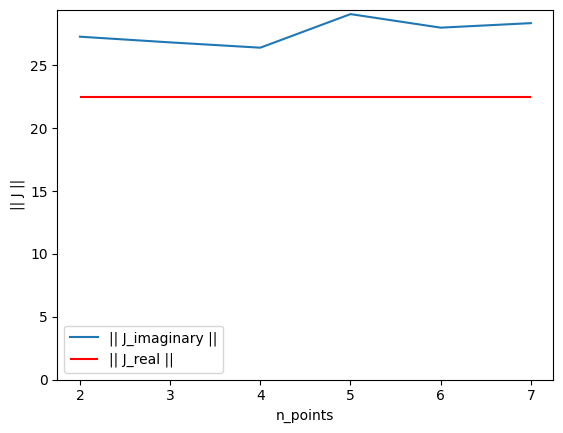

In [29]:
w_norms = [op.weight.norm().item() for op in imaginary_operators]
plt.plot(range(2, 8), w_norms, label = "|| J_imaginary ||")
plt.hlines(operator.weight.norm().item(), 2, 7, color="red", label = "|| J_real ||")
plt.ylim(bottom=0)
plt.legend()
plt.ylabel("|| J ||")
plt.xlabel("n_points")

In [42]:
operator_dict = imaginary_operators[1].__dict__.copy()
operator_dict["beta"] = 0.4
img_operator = operators.LinearRelationOperator(**operator_dict)

print(img_operator.weight.norm().item(), img_operator.bias.norm().item())

for sample in test.samples:
    pred = img_operator(sample.subject).predictions[:3]
    print(f"{sample} | pred: {[f'{p.token} ({p.prob:.2f})' for p in pred]}")

26.828125 205.625
Brazil -> Bras\u00edlia | pred: [' Bras (0.79)', ' Rio (0.08)', ' Brazil (0.07)']
Canada -> Ottawa | pred: [' Ottawa (0.44)', ' Toronto (0.24)', ' Vancouver (0.06)']
Chile -> Santiago | pred: [' Santiago (0.98)', ' Chile (0.01)', '  (0.00)']
China -> Beijing | pred: [' Beijing (0.98)', ' Shanghai (0.02)', ' China (0.00)']
Colombia -> Bogot\u00e1 | pred: [' Bog (0.89)', '  (0.03)', ' Colombia (0.02)']
Egypt -> Cairo | pred: [' Cairo (1.00)', ' Egypt (0.00)', ' Alexandria (0.00)']
France -> Paris | pred: [' Paris (0.99)', ' French (0.00)', ' France (0.00)']
Japan -> Tokyo | pred: [' Tokyo (1.00)', ' Japan (0.00)', ' Osaka (0.00)']
Mexico -> Mexico City | pred: [' Mexico (0.96)', ' Los (0.01)', ' New (0.01)']
Nigeria -> Abuja | pred: [' New (0.15)', ' Nigeria (0.12)', '  (0.11)']
Spain -> Madrid | pred: [' Madrid (0.97)', ' Barcelona (0.01)', '  (0.00)']
Turkey -> Ankara | pred: [' Ankara (0.66)', ' Istanbul (0.33)', ' Turkey (0.01)']
United States -> Washington D.C. | p

Text(0.5, 0, 'n_points')

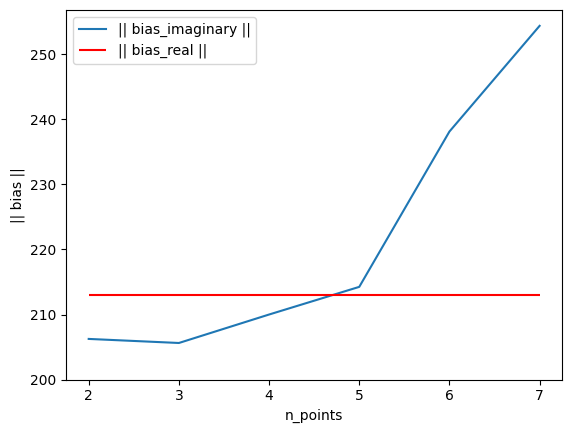

In [30]:
b_norms = [op.bias.norm().item() for op in imaginary_operators]
plt.plot(range(2, 8), b_norms, label = "|| bias_imaginary ||")
plt.hlines(operator.bias.norm().item(), 2, 7, color="red", label = "|| bias_real ||")
plt.ylim(bottom=200)
plt.legend()
plt.ylabel("|| bias ||")
plt.xlabel("n_points")

In [14]:
for sample in test.samples:
    pred = operator_i(sample.subject).predictions[:3]
    print(f"{sample} | pred: {[f'{p.token} ({p.prob:.2f})' for p in pred]}")

Brazil -> Bras\u00edlia | pred: [' Bras (0.85)', ' Brazil (0.08)', ' Sao (0.05)']
Canada -> Ottawa | pred: [' Toronto (0.29)', ' Ottawa (0.29)', ' Canada (0.23)']
Chile -> Santiago | pred: [' Santiago (1.00)', ' Chile (0.00)', ' Chilean (0.00)']
China -> Beijing | pred: [' Beijing (0.99)', ' China (0.01)', ' Shanghai (0.00)']
Colombia -> Bogot\u00e1 | pred: [' Bog (0.90)', ' Colombia (0.09)', ' Lima (0.00)']
Egypt -> Cairo | pred: [' Cairo (0.99)', ' Egypt (0.01)', ' Egyptian (0.00)']
France -> Paris | pred: [' Paris (0.85)', ' France (0.14)', ' French (0.01)']
Japan -> Tokyo | pred: [' Tokyo (0.97)', ' Japan (0.01)', ' Osaka (0.01)']
Mexico -> Mexico City | pred: [' Mexico (1.00)', ' Mé (0.00)', 'Mexico (0.00)']
Nigeria -> Abuja | pred: [' Nigeria (0.76)', ' Abu (0.16)', ' Lag (0.03)']
Spain -> Madrid | pred: [' Madrid (0.87)', ' Spain (0.09)', ' Mexico (0.01)']
Turkey -> Ankara | pred: [' Ankara (0.75)', ' Istanbul (0.23)', ' Turkey (0.02)']
United States -> Washington D.C. | pred: [